In [1]:
import os
os.chdir(r'/Users/rmccrickerd/desktop/jdheston')

In [2]:
import numpy as np
import pandas as pd
from jdheston import jdheston as jdh
from jdheston import utils as uts
from jdheston import config as cfg
from matplotlib import pyplot as plt
from scipy.stats import norm

In [3]:
nx = np.newaxis
cfg.config(scale=1.5,print_keys=False)

In [4]:
expiries = np.array([1/12,3/12,6/12,1])
labels = ['1m','3m','6m','1y']

In [5]:
plt.rcParams['figure.figsize'] = [4,4/1.618]
plt.rcParams['legend.loc'] = 'best'

In [6]:
sigma_max = 0.10

In [7]:
T = np.array([1/12,3/12,6/12,1])[:,nx]
Δ = np.linspace(5,95,19)[nx,:]/100
k = norm.ppf(Δ)*sigma_max*np.sqrt(T)

In [8]:
pd.DataFrame(k,index=T[:,0],columns=np.round(Δ[0,:],2))

,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
0.083333,-0.047483,-0.036995,-0.029919,-0.024296,-0.019471,-0.015138,-0.011123,-0.007314,-0.003628,0.0,0.003628,0.007314,0.011123,0.015138,0.019471,0.024296,0.029919,0.036995,0.047483
0.250000,-0.082243,-0.064078,-0.051822,-0.042081,-0.033724,-0.026220,-0.019266,-0.012667,-0.006283,0.0,0.006283,0.012667,0.019266,0.026220,0.033724,0.042081,0.051822,0.064078,0.082243
0.500000,-0.116309,-0.090619,-0.073287,-0.059512,-0.047694,-0.037081,-0.027246,-0.017914,-0.008886,0.0,0.008886,0.017914,0.027246,0.037081,0.047694,0.059512,0.073287,0.090619,0.116309
1.000000,-0.164485,-0.128155,-0.103643,-0.084162,-0.067449,-0.052440,-0.038532,-0.025335,-0.012566,0.0,0.012566,0.025335,0.038532,0.052440,0.067449,0.084162,0.103643,0.128155,0.164485


In [9]:
sig = np.array([7,8,9,10])/100

In [10]:
jump_weight =  0.9
rho0, rho1  = -0.0,-0.5
vee0, vee1  =  0.5, 1.0
eps0, eps1  =  0.0, 1.0

In [11]:
tau0 = np.array([0,1/12,3/12,6/12])
sig0   = jump_weight**0.5*sig
rho0   = np.array([rho0])*np.ones_like(tau0)
vee0   = np.array([vee0])*np.ones_like(tau0)
eps0   = np.array([eps0])*np.ones_like(tau0)

In [12]:
tau1 = np.array([0,1/12,3/12,6/12])
sig1   = (1 - jump_weight)**0.5*sig
rho1   = np.array([rho1])*np.ones_like(tau1)
vee1   = np.array([vee1])*np.ones_like(tau1)
eps1   = np.array([eps1])*np.ones_like(tau1)

In [13]:
params0  = np.array([tau0, sig0, rho0, vee0, eps0]).T
params1  = np.array([tau1, sig1, rho1, vee1, eps1]).T

In [14]:
call_prices = jdh.jdh2f_pricer(T, k, [params0, params1])
model_vols = jdh.surface(T, k, call_prices)

In [15]:
from cycler import cycler

In [16]:
plt.rcParams['axes.prop_cycle'] = cycler(color=['r','gold','g','b'])

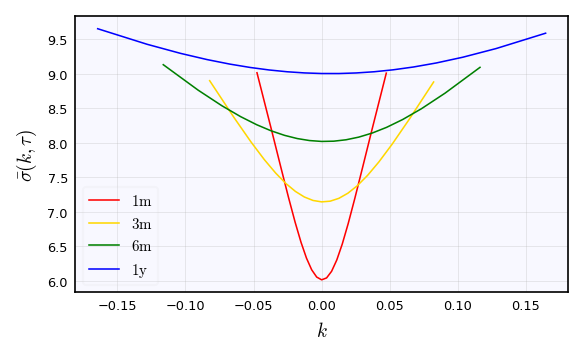

In [17]:
plot,axes = plt.subplots()
for i in range(len(T[:,0])):
    axes.plot(k[i,:],100*model_vols[i,:])

axes.set_ylabel(r'$\bar{\sigma}(k,\tau)$')
axes.set_xlabel(r'$k$')
axes.legend([r'$\mathrm{1m}$',
             r'$\mathrm{3m}$',
             r'$\mathrm{6m}$',
             r'$\mathrm{1y}$'])
plt.tight_layout()

In [18]:
num_steps = 252*4
time_grid = np.linspace(0, 1, num_steps + 1)[nx,:]
time_step = 1/num_steps

In [19]:
rho0, rho1  = -0.0,-0.5
vee0, vee1  =  0.5, 1.0
eps0, eps1  =  0.0, 1.0

In [20]:
num_paths = 2**17
np.random.seed(1729)
size = (num_paths, num_steps)
dW02 = np.random.normal(size=size)*np.sqrt(time_step)
dW11 = np.random.normal(size=size)*np.sqrt(time_step)
dW12 = rho1*dW11 + np.sqrt(1 - rho1**2)*np.random.normal(size=size)*np.sqrt(time_step)

In [21]:
num_paths

131072

Now make forward variance grids

In [22]:
indices = np.sum(tau1[:,nx] <= time_grid, axis=0) - 1
sig1_grid = sig1[indices][nx,:]

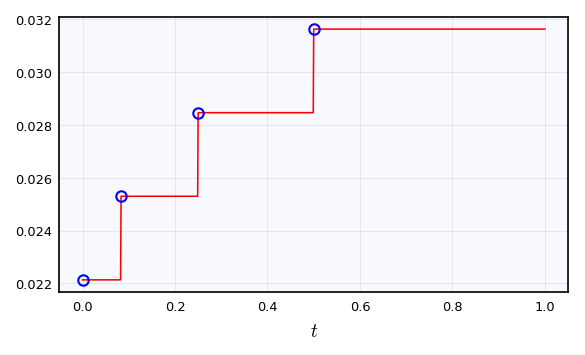

In [23]:
plot,axes = plt.subplots()
axes.plot(time_grid[0,:], sig1_grid[0,:])
axes.plot(tau1, sig1, 'bo')
# axes.set_ylabel(r'$\bar{\sigma}(k,\tau)$')
axes.set_xlabel(r'$t$')
plt.tight_layout()

In [24]:
X1 = np.ones((num_paths, num_steps + 1))
dt = time_step
for i in range(num_steps):
    X1[:,i+1] = np.maximum(0, X1[:,i] + (vee1*np.sqrt(X1[:,i])*dW11[:,i] + (1 - X1[:,i])*dt)/eps1)

In [25]:
V1 = sig1_grid**2*X1

In [26]:
EV1 = np.mean(V1, axis=0, keepdims=True)

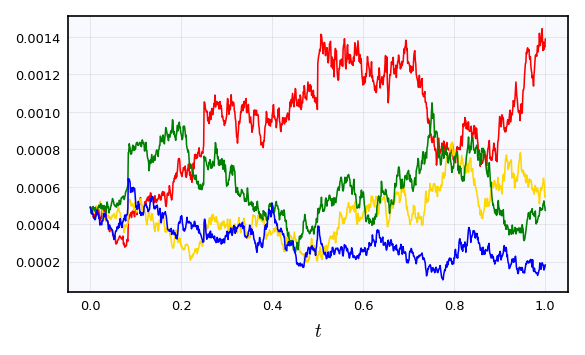

In [27]:
plot,axes = plt.subplots()
axes.plot(time_grid[0,:], V1[0:4,:].T)
# axes.plot(time_grid[0,:], EV1[0,:], 'k:')
# axes.set_ylabel(r'$\bar{\sigma}(k,\tau)$')
axes.set_xlabel(r'$t$')
plt.tight_layout()

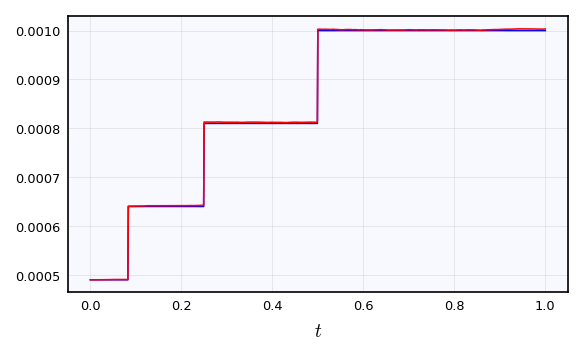

In [28]:
plot,axes = plt.subplots()
axes.plot(time_grid[0,:], sig1_grid[0,:]**2, 'b')
axes.plot(time_grid[0,:], EV1[0,:], 'r')
# axes.set_ylabel(r'$\bar{\sigma}(k,\tau)$')
axes.set_xlabel(r'$t$')
plt.tight_layout()

In [29]:
S1 = np.sqrt(V1)
H1 = np.zeros((num_paths, num_steps + 1))
H1[:,1:] = np.cumsum(S1[:,:-1]*dW12 - 0.5*V1[:,:-1]*dt, axis=1)

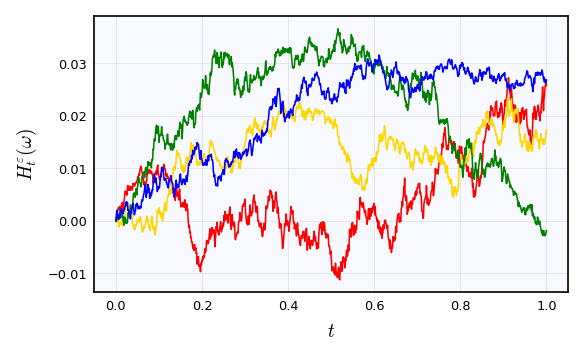

In [30]:
plot,axes = plt.subplots()
axes.plot(time_grid[0,:], H1[0:4,:].T)
# axes.plot(time_grid[0,:], EV1[0,:], 'k:')
axes.set_ylabel(r'$H^\varepsilon_t(\omega)$')
axes.set_xlabel(r'$t$')
plt.tight_layout()

In [31]:
EH1 = np.mean(H1, axis=0, keepdims=True)

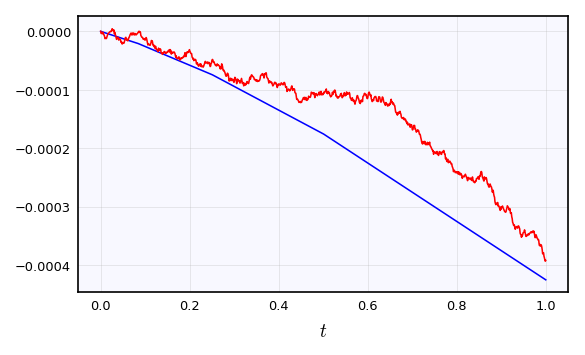

In [32]:
plot,axes = plt.subplots()
axes.plot(time_grid[0,:], -0.5*np.cumsum(sig1_grid[0,:]**2)*dt, 'b')
axes.plot(time_grid[0,:], EH1[0,:], 'r')
# axes.set_ylabel(r'$\bar{\sigma}(k,\tau)$')
axes.set_xlabel(r'$t$')
plt.tight_layout()

In [33]:
def inverse_gaussian(δ,γ,size):
    return np.random.wald(δ/γ,δ**2,size=size)

In [34]:
sig0_grid = sig0[indices][nx,:]

In [35]:
delta = time_step/vee0
gamma = 1/vee0
X0 = inverse_gaussian(delta, gamma, size=(num_paths, num_steps + 1))/time_step
V0 = sig0_grid**2*X0

In [36]:
EV0 = np.mean(V0, axis=0, keepdims=True)

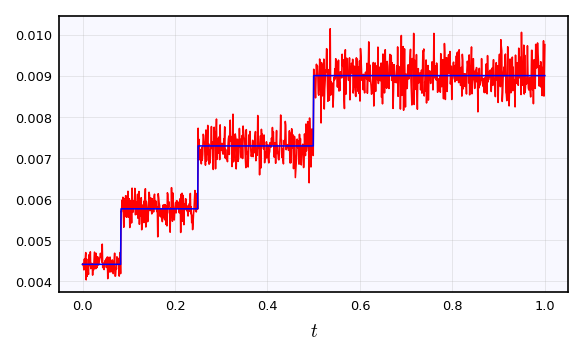

In [37]:
plot,axes = plt.subplots()
axes.plot(time_grid[0,:], EV0[0,:], 'r')
axes.plot(time_grid[0,:], sig0_grid[0,:]**2, 'b')
# axes.set_ylabel(r'$\bar{\sigma}(k,\tau)$')
axes.set_xlabel(r'$t$')
plt.tight_layout()

In [38]:
beta = rho0/sig0_grid/vee1 - 0.5
mu = -sig0_grid*rho0/vee1

In [39]:
VV0 = np.cumsum(V0, axis=1)*dt
t = time_grid

In [40]:
S0 = np.sqrt(V0)
H0 = np.zeros((num_paths, num_steps + 1))
A = np.sqrt(1 - rho0**2)*np.cumsum(S0[:,:-1]*dW02, axis=1)
B = np.cumsum((rho0/sig0_grid[:,:-1]/vee1 - 0.5)*V0[:,:-1], axis=1)*dt
C = - np.cumsum(sig0_grid[:,:-1]*rho0/vee1, axis=1)*dt
H0[:,1:] = A + B + C

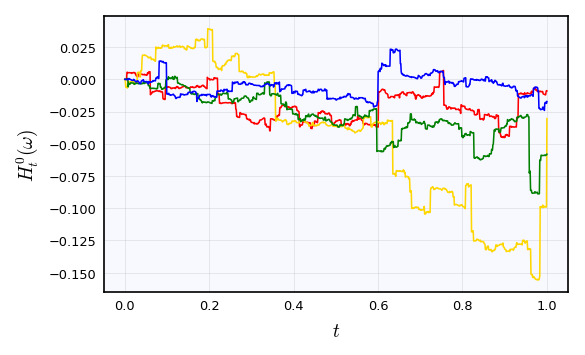

In [41]:
plot,axes = plt.subplots()
axes.plot(time_grid[0,:], H0[0:4,:].T)
# axes.plot(time_grid[0,:], EV1[0,:], 'k:')
axes.set_ylabel(r'$H^0_t(\omega)$')
axes.set_xlabel(r'$t$')
plt.tight_layout()

In [42]:
EH0 = np.mean(H0, axis=0, keepdims=True)

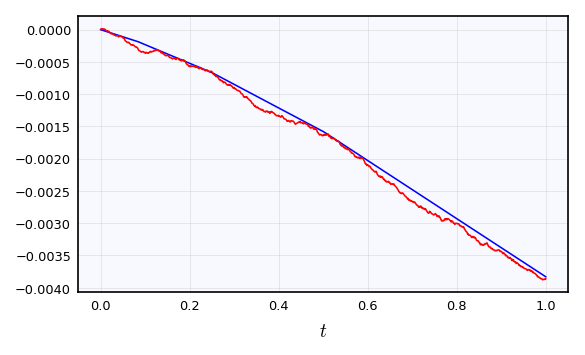

In [43]:
plot,axes = plt.subplots()
axes.plot(time_grid[0,:], -0.5*np.cumsum(sig0_grid[0,:]**2)*dt, 'b')
axes.plot(time_grid[0,:], EH0[0,:], 'r')
# axes.set_ylabel(r'$\bar{\sigma}(k,\tau)$')
axes.set_xlabel(r'$t$')
plt.tight_layout()

In [44]:
H = H0 + H1

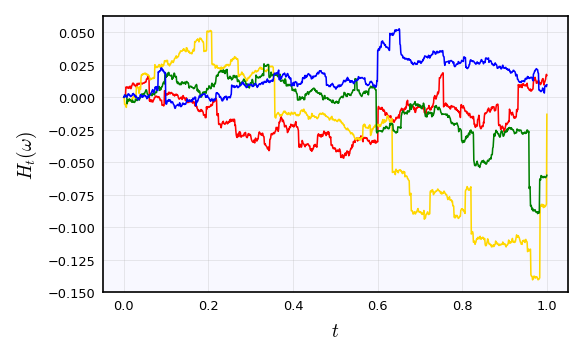

In [45]:
plot,axes = plt.subplots()
axes.plot(time_grid[0,:], H[0:4,:].T)
# axes.plot(time_grid[0,:], EV1[0,:], 'k:')
axes.set_ylabel(r'$H_t(\omega)$')
axes.set_xlabel(r'$t$')
plt.tight_layout()

In [46]:
EeH = np.mean(np.exp(H), axis=0, keepdims=True)

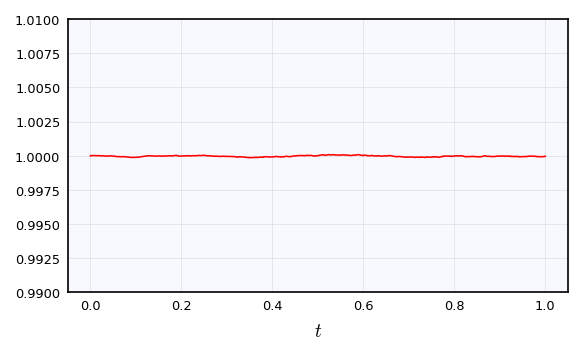

In [47]:
plot,axes = plt.subplots()
axes.plot(time_grid[0,:], EeH[0,:])
# axes.plot(time_grid[0,:], EV1[0,:], 'k:')
axes.set_ylim([0.99,1.01])
# axes.set_ylabel(r'$H_t(\omega)$')
axes.set_xlabel(r'$t$')
plt.tight_layout()

In [48]:
expiry_indices = (num_steps*expiries).astype(int)

In [49]:
time_grid[:,expiry_indices]

array([[0.08333333, 0.25      , 0.5       , 1.        ]])

In [50]:
simulated_payoffs = 0.5*(np.maximum(0, np.exp(H[:,expiry_indices])[:,:,nx] - np.exp(k)[nx,:,:]) 
                         + np.maximum(0, np.exp(k)[nx,:,:] - np.exp(H[:,expiry_indices])[:,:,nx] ) 
                         + 1 - np.exp(k)[nx,:,:])
simulated_prices = np.mean(simulated_payoffs, axis=0)

In [51]:
simulated_vols = jdh.surface(T, k, simulated_prices)

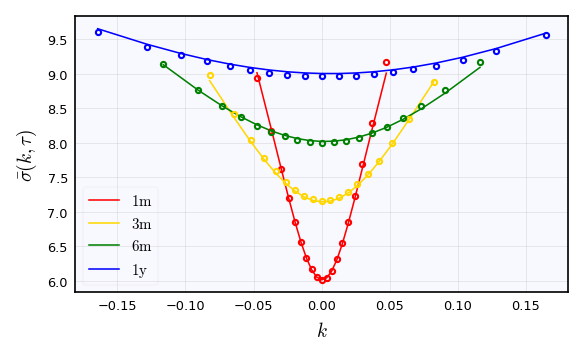

In [53]:
plot,axes = plt.subplots()
for i in range(len(T[:,0])):
    axes.plot(k[i,:],100*model_vols[i,:])
for i in range(len(T[:,0])):
    axes.plot(k[i,:],100*simulated_vols[i,:],marker='.',linestyle='')
    
axes.set_ylabel(r'$\bar{\sigma}(k,\tau)$')
axes.set_xlabel(r'$k$')
axes.legend([r'$\mathrm{1m}$',
             r'$\mathrm{3m}$',
             r'$\mathrm{6m}$',
             r'$\mathrm{1y}$'])
plt.tight_layout()
plt.savefig('plots/jumpweight090')